In [1]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import math

In [2]:
#conda install -c conda-forge matplotlib

In [3]:
#conda install -c anaconda scipy

In [4]:
def showImg(img, cmap=None):
#     plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.imshow(img, cmap=cmap)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

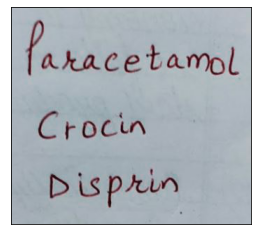

In [5]:
img1 = cv2.imread('char_seg.jpg') 
showImg(img1, cmap='gray')

In [6]:
print(img1.ndim)
print(img1.shape)

3
(311, 343, 3)


In [7]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
print(img2.shape)

(311, 343)


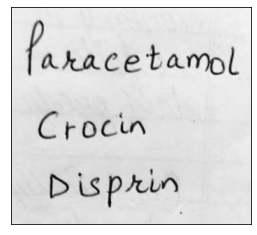

In [8]:
showImg(img2, cmap='gray')

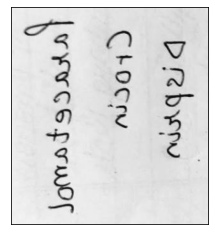

In [9]:
img3 = np.transpose(img2)
showImg(img3, cmap='gray')

In [10]:
def createKernel(kernelSize, sigma, theta):
    "create anisotropic filter kernel according to given parameters"
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

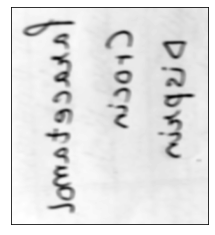

In [11]:
imgFiltered1 = cv2.filter2D(img3, -1, createKernel(9, 4, 5), borderType=cv2.BORDER_REPLICATE)
showImg(imgFiltered1, cmap='gray')

In [12]:
def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img
img4 = normalize(imgFiltered1)

(m, s) = cv2.meanStdDev(imgFiltered1)
m[0][0]

173.42358422468666

In [13]:
summ = applySummFunctin(img4)
print(summ.ndim)
print(summ.shape)

1
(311,)


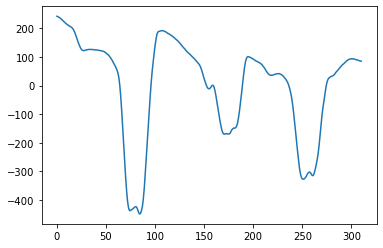

In [14]:
plt.plot(summ)
plt.show()

In [15]:
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'") 
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y


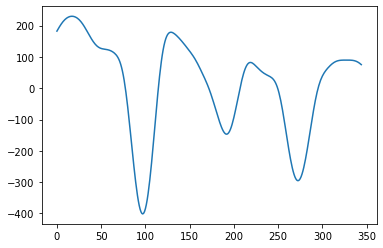

In [16]:
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
smoothed = smooth(summ, 35)
plt.plot(smoothed)
plt.show()

In [17]:
from scipy.signal import argrelmin
mins = argrelmin(smoothed, order=2)
arr_mins = np.array(mins)

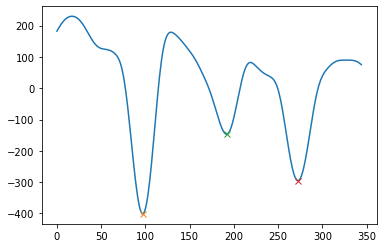

In [18]:
plt.plot(smoothed)
plt.plot(arr_mins, smoothed[arr_mins], "x")
plt.show()

In [19]:
img4.shape

(343, 311)

In [20]:
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines
    
def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'") 
    if orient == 'vertical': 
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                if i==1:
                    line = l
                    plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                    plt.axis('off')
                    plt.title("Line #{0}".format(i))
                    _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.figure(figsize = (15,10))
    plt.show()
    

In [21]:
found_lines = crop_text_to_lines(img3, arr_mins[0])

x1= 0 , x2= 97 , Diff=  97
x1= 97 , x2= 192 , Diff=  95
x1= 192 , x2= 272 , Diff=  80


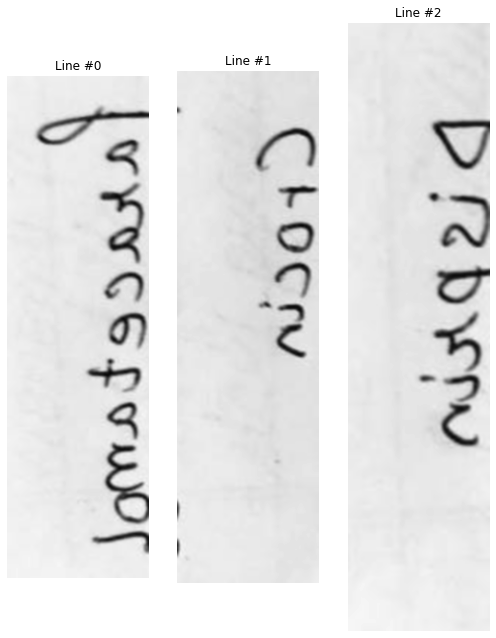

<Figure size 1080x720 with 0 Axes>

In [22]:
display_lines(found_lines)

In [23]:
def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res
    

In [24]:
res_lines = transpose_lines(found_lines)

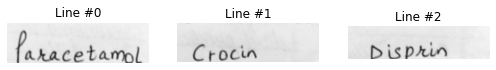

<Figure size 1080x720 with 0 Axes>

In [25]:
display_lines(res_lines)

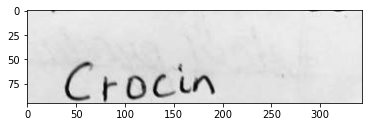

In [26]:
plt.imshow(res_lines[1],cmap='gray')

In [27]:
count = 0 
for i in res_lines:
    count = count+1
    plt.imsave('data/line{0}.jpg'.format(count),i,cmap='gray')

line1


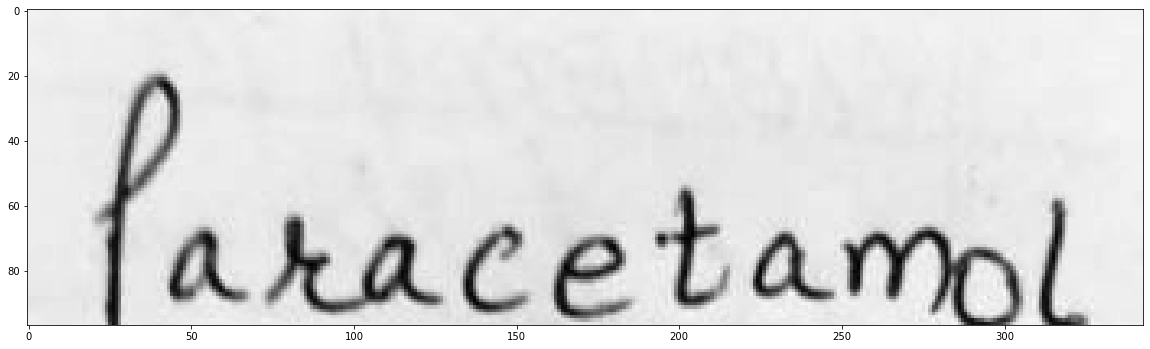

line2


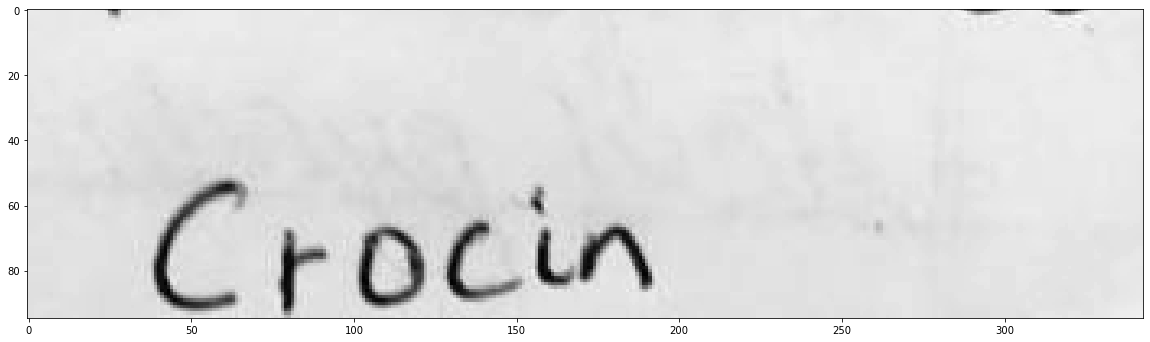

line3


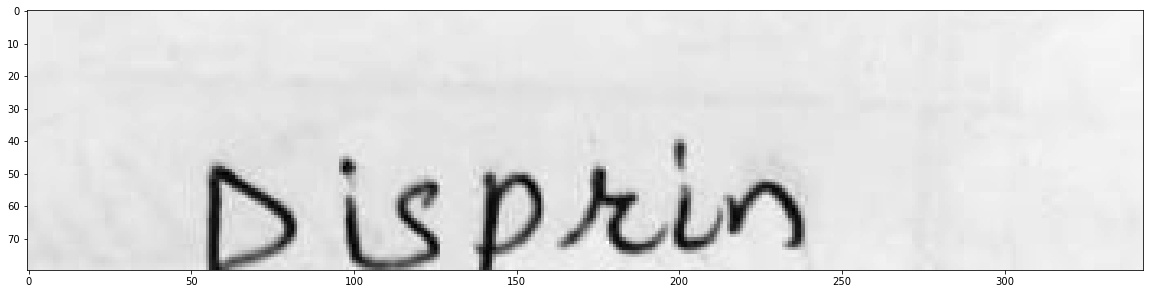

IndexError: list index out of range

<Figure size 1440x1440 with 0 Axes>

In [28]:
for i in range(5):
    plt.figure(figsize=(20,20))
#     plt.xticks([]), plt.yticks([])
    plt.imshow(res_lines[i],cmap='gray')
    print('line{0}'.format(i+1))
    plt.show()
